# Predicting Latent Heating by Adding Changes in Features

Mainly looking at how prediction would work if the difference in subsequent
data points was added as a feature itself. There will be some feature selection
and data analysis to determine good features to use and what data points should
be considered extreme LH.

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import f1_score
from itertools import combinations
from tqdm.notebook import tqdm

In [2]:
# Datafile
df = pd.read_csv("./data_table_NA850_nonfiltered_updated.csv")
df.head()

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,LH,Time,Lat,Lon
0,7.060846,7.267001,0.000642,1021.565625,-11.894431,-5.276164,12.888080,2000010100,25.064459,-35.368896
1,7.100183,7.474899,-0.000296,1021.084141,-11.230261,-3.172798,-10.217120,2000010103,24.480576,-36.771637
2,7.068231,7.335827,0.000323,1020.302969,-10.246526,-1.993664,0.511768,2000010106,24.649042,-37.882874
3,7.328638,7.064822,0.000828,1020.585156,-9.889462,-1.943067,-16.420087,2000010109,24.122194,-38.753021
4,7.598169,7.333828,0.000373,1022.448281,-10.461138,-1.204948,-6.642615,2000010112,24.368916,-40.022919


In [3]:
# Add some diff data and drop Lat/Lon/Time
df['dAirTemp'] = df.AirTemp.diff()
df['dQV'] = df.QV.diff()
df['dOmega'] = df.Omega.diff()
df['dSeaLevPress'] = df.SeaLevPress.diff()
df['dUWinds'] = df.UWinds.diff()
df['dVWinds'] = df.VWinds.diff()
df['dLat'] = df.Lat.diff()
df['dLon'] = df.Lon.diff()

df.loc[0, 'dLat'] = 0
df.loc[0, 'dLon'] = 0
df.loc[0, 'dUWinds'] = 0
df.loc[0, 'dVWinds'] = 0
df.loc[0, 'dSeaLevPress'] = 0
df.loc[0, 'dOmega'] = 0
df.loc[0, 'dAirTemp'] = 0
df.loc[0, 'dQV'] = 0

df['Time'] = pd.to_datetime(df.Time, format="%Y%m%d%H")
df = df.set_index('Time')
df = df.drop(axis=1, labels=["Lat", "Lon"])

In [4]:
# Scale the data using a RobustScaler
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df),
                  columns=df.columns,
                  index=df.index)

## Quick Look at Kendall Correlations

In [5]:
df.describe()

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,LH,dAirTemp,dQV,dOmega,dSeaLevPress,dUWinds,dVWinds,dLat,dLon
count,1.732000e+03,1.732000e+03,1.732000e+03,1.732000e+03,1732.000000,1732.000000,1.732000e+03,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000
mean,-9.374876e-02,-2.657104e-01,-3.329808e-01,1.459076e-01,0.012800,-0.028583,6.680829e-01,0.048794,0.005509,0.001068,-0.032544,0.021760,0.002498,0.032905,1.077419
std,1.788178e+00,7.234944e-01,1.504368e+00,8.840828e-01,0.682365,0.844551,1.952211e+00,1.849300,1.490525,1.473869,0.692870,1.160012,1.268670,3.540790,8.526088
min,-6.304448e+00,-2.204174e+00,-1.577670e+01,-1.982083e+00,-2.421385,-2.644464,-5.868978e+00,-11.342577,-11.828216,-10.692983,-6.221531,-8.564673,-9.083783,-36.277584,-54.418667
25%,-5.653561e-01,-7.241540e-01,-5.758553e-01,-4.368651e-01,-0.500500,-0.549006,-2.073239e-01,-0.506030,-0.484391,-0.497573,-0.532421,-0.490370,-0.497380,-0.488911,-0.504643
50%,-1.064524e-15,-1.804655e-16,-1.923273e-17,-1.632657e-14,0.000000,0.000000,1.962406e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.346439e-01,2.758460e-01,4.241447e-01,5.631349e-01,0.499500,0.450994,7.926761e-01,0.493970,0.515609,0.502427,0.467579,0.509630,0.502620,0.511089,0.495357
max,7.090267e+00,8.210361e-01,4.854562e+00,3.974510e+00,2.267694,4.169482,2.432005e+01,20.371825,11.220097,9.983576,5.714968,7.818008,8.792477,33.672500,83.203138


<AxesSubplot:>

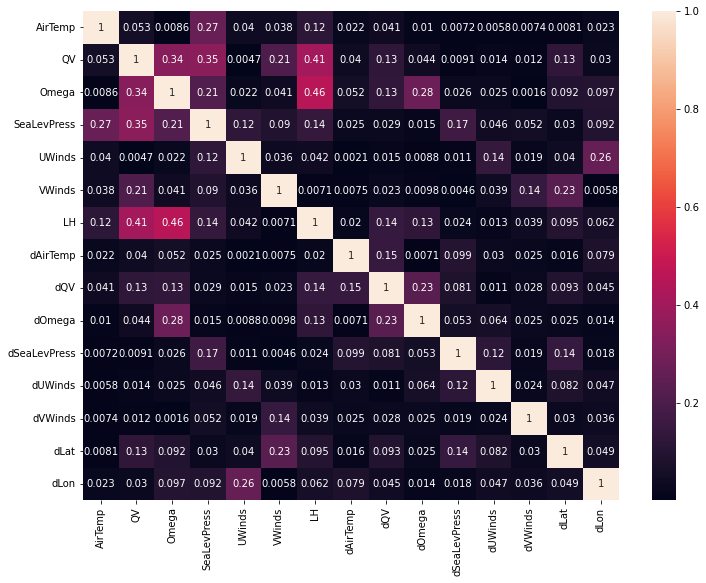

In [6]:
fig1, ax1 = plt.subplots(figsize=(12, 9))
sns.heatmap(abs(df.corr('kendall')), ax=ax1, annot=True)

The correlations here are overall fairly weak. Because of the lack of options
I'll go ahead and sort the correlations on Latent Heating from highest to
lowest correlation. I'll then create several predictors where a feature is
added in descending order of correlation.


In [7]:
desc_corr = abs(df.corr('kendall'))[['LH']].sort_values(by='LH', ascending=False)
desc_corr

,LH
LH,1.000000
Omega,0.455173
QV,0.406391
dQV,0.142112
SeaLevPress,0.140413
dOmega,0.130199
AirTemp,0.121293
dLat,0.095257
dLon,0.061879
UWinds,0.041764


## Label Outliers as Extremes

<AxesSubplot:xlabel='LH'>

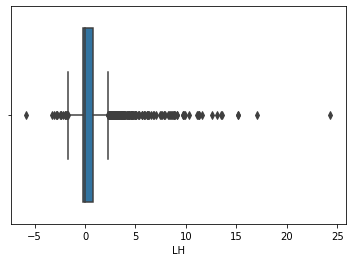

In [8]:
# Quick boxplot to see outliers
sns.boxplot(x=df["LH"])

The default uses IQR range for outlier determination with Whisker length 1.5

In [9]:
LQ = df.LH.quantile(0.25)
UQ = df.LH.quantile(0.75)
bound = 1.5 * (UQ - LQ) #Whisker length * IQR
lower_bound = LQ - bound
upper_bound = UQ + bound
df["Extreme"] = np.where( (df["LH"] > upper_bound) | (df["LH"]  < lower_bound), 1, 0)

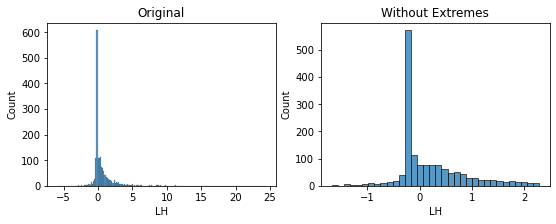

In [10]:
fig3, ax3 =plt.subplots(1, 2, figsize=(9,3))
sns.histplot(df["LH"], ax=ax3[0])
ax3[0].title.set_text("Original")
sns.histplot(df["LH"][df.Extreme == 0], ax=ax3[1])
ax3[1].title.set_text("Without Extremes")

## Non-linear SVM

In [11]:
data_Y = df["Extreme"]
data_X = df.drop(["Extreme", "LH"], axis=1)

In [12]:
res_combined = []
for index in range(2, len(desc_corr)):
    X_train, X_test, y_train, y_test = train_test_split(data_X[desc_corr.index[1:index]], data_Y, test_size=0.25, random_state=738)
    clf_rbf = svm.SVC(kernel = 'rbf', C = 10)
    clf_rbf.fit(X_train, y_train)
    y_pred = clf_rbf.predict(X_test)
    res_combined.append(f1_score(y_test, y_pred))
res_combined

[0.5205479452054794,
 0.5205479452054794,
 0.5205479452054794,
 0.547945205479452,
 0.4788732394366197,
 0.4722222222222222,
 0.4722222222222222,
 0.47058823529411764,
 0.44776119402985076,
 0.5205479452054794,
 0.5599999999999999,
 0.5405405405405405,
 0.4788732394366197]

In [37]:
data_X["Omega"]

Time
2000-01-01 00:00:00    0.705290
2000-01-01 03:00:00    0.040104
2000-01-01 06:00:00    0.479295
2000-01-01 09:00:00    0.837784
2000-01-01 12:00:00    0.514822
                         ...   
2000-12-17 18:00:00   -0.336920
2000-12-17 21:00:00   -0.882866
2000-12-18 00:00:00   -0.923736
2000-12-18 03:00:00    0.102516
2000-12-18 06:00:00   -0.401599
Name: Omega, Length: 1732, dtype: float64

The best result was using all but the last 2 features. I was hoping for a
monotonic change in F1 score as we added features with higher correlation.

A bit excessive but since the processing is so fast I am just going to try
every feature combination possible.

In [13]:
combs = []
for x in range(1, len(desc_corr)):
    combs += [list(y) for y in combinations(desc_corr.index[1:], x)]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data_X[['Omega', 'dVWinds']], data_Y, test_size=0.25, random_state=738)
clf_rbf = svm.SVC(kernel = 'rbf', C = 10)
clf_rbf.fit(X_train, y_train)
y_pred = clf_rbf.predict(X_test)
res_comb.append(f1_score(y_test, y_pred))

C:\Users\srimo\miniconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


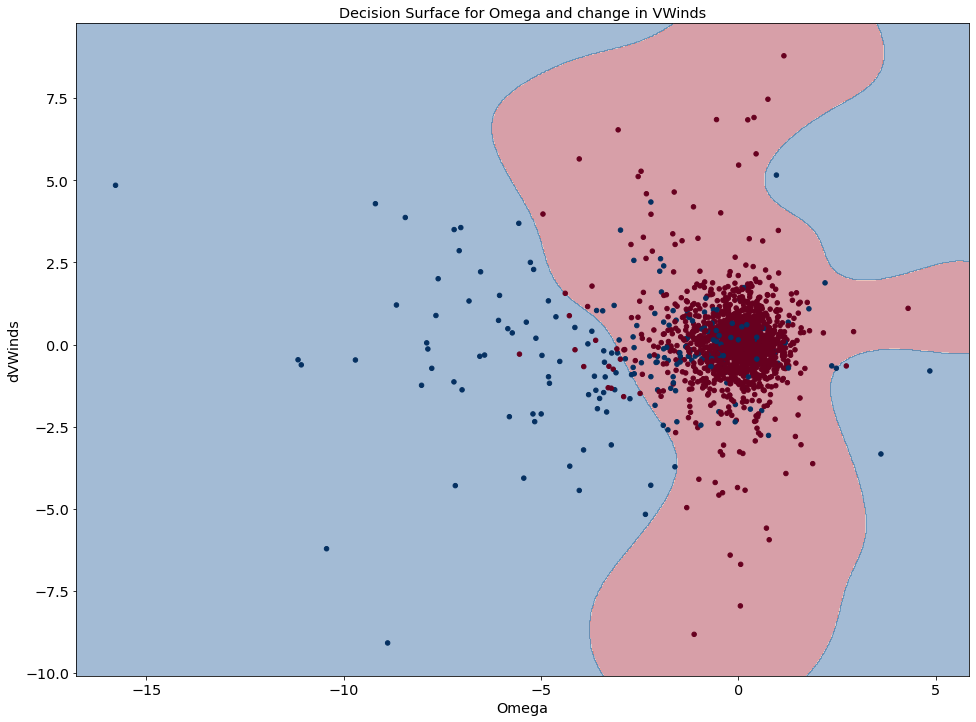

In [46]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots(figsize=(16,12))
# title for the plots
title = ('Decision Surface for Omega and change in VWinds')
# Set-up grid for plotting.
X0, X1 = data_X["Omega"], data_X["dVWinds"]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_rbf, xx, yy, cmap=plt.cm.RdBu, alpha=0.4)
ax.scatter(X0, X1, c=df.Extreme, cmap=plt.cm.RdBu, s=20)
ax.set_ylabel('dVWinds')
ax.set_xlabel('Omega')
ax.set_title(title)
plt.show()

In [ ]:
best_index = res_comb.index(max(res_comb))
print("Best F1 score of %f using\n%s" % (res_comb[best_index], str(combs[best_index])))

# Conclusion
Adding the change in the features as a feature itself added relevant features,
as indicated by the result of the F1 tests.

The extreme data points were identified using interquartile range, labelling
200 total data points of the 1732 possible as extreme.

The best performing feature set, achieving an F1 score of 0.643, was:
* Omega
* Change in Omega
* Sea Level Pressure
* Change in Sea Level Pressure
* UWinds
* Change in UWinds
* Change in VWinds